# Image Scaling Preprocessing for VLLM Model

This notebook performs image scaling preprocessing on the dataset to standardize all images before processing with VLLM model.

## Objectives:
- Load dataset from CSV file
- Scale images to standardized dimensions
- Maintain aspect ratio while resizing
- Save processed images for VLLM model input

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration parameters
TARGET_SIZE = (224, 224)  # Standard size for most vision models
QUALITY = 95  # JPEG quality for saved images

# Paths configuration
CSV_PATH = "../../data/raw/dataset_with_mood.csv"
ORIGINAL_IMAGES_PATH = "../../Images/"  # Path to Images folder
SCALED_IMAGES_PATH = "../../data/scaled_images/"

print(f"Target image size: {TARGET_SIZE}")
print(f"CSV file path: {CSV_PATH}")
print(f"Original images path: {ORIGINAL_IMAGES_PATH}")
print(f"Scaled images output path: {SCALED_IMAGES_PATH}")

Target image size: (224, 224)
CSV file path: ../../data/raw/dataset_with_mood.csv
Original images path: ../../Images/
Scaled images output path: ../../data/scaled_images/


In [3]:
# Load dataset
try:
    df = pd.read_csv(CSV_PATH)
    print(f"Dataset loaded successfully!")
    print(f"Total rows: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    
    # Display first few rows
    print("\nFirst 5 rows:")
    display(df.head())
    
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_PATH}")
    print("Please check the file path and try again.")

Dataset loaded successfully!
Total rows: 158915
Columns: ['image_filename', 'caption_desc', 'emotion_label']

First 5 rows:


,image_filename,caption_desc,emotion_label
0,1000092795.jpg,two young guys with shaggy hair look at their ...,Sad
1,1000092795.jpg,"two young , white males are outside near many ...",Sad
2,1000092795.jpg,two men in green shirts are standing in a yard .,Sad
3,1000092795.jpg,a man in a blue shirt standing in a garden .,Love
4,1000092795.jpg,two friends enjoy time spent together .,Sad


In [4]:
# Get unique image filenames
unique_images = df['image_filename'].unique()
print(f"Total unique images to process: {len(unique_images)}")
print(f"Sample image filenames: {unique_images[:5]}")

Total unique images to process: 31783
Sample image filenames: ['1000092795.jpg' '10002456.jpg' '1000268201.jpg' '1000344755.jpg'
 '1000366164.jpg']


In [5]:
# Create output directory if it doesn't exist
os.makedirs(SCALED_IMAGES_PATH, exist_ok=True)
print(f"Output directory created/verified: {SCALED_IMAGES_PATH}")

Output directory created/verified: ../../data/scaled_images/


In [6]:
def scale_image_with_padding(image_path, target_size=(224, 224), fill_color=(255, 255, 255)):
    """
    Scale image to target size while maintaining aspect ratio using padding.
    
    Args:
        image_path (str): Path to the input image
        target_size (tuple): Target size (width, height)
        fill_color (tuple): RGB color for padding (default: white)
    
    Returns:
        PIL.Image: Scaled image with padding
    """
    try:
        # Open and convert image to RGB
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            
            # Calculate scaling factor to fit within target size
            img_ratio = img.width / img.height
            target_ratio = target_size[0] / target_size[1]
            
            if img_ratio > target_ratio:
                # Image is wider, scale by width
                new_width = target_size[0]
                new_height = int(target_size[0] / img_ratio)
            else:
                # Image is taller, scale by height
                new_height = target_size[1]
                new_width = int(target_size[1] * img_ratio)
            
            # Resize image
            img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            
            # Create new image with target size and fill color
            new_img = Image.new('RGB', target_size, fill_color)
            
            # Calculate position to center the resized image
            x_offset = (target_size[0] - new_width) // 2
            y_offset = (target_size[1] - new_height) // 2
            
            # Paste resized image onto the new image
            new_img.paste(img_resized, (x_offset, y_offset))
            
            return new_img
            
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def scale_image_stretch(image_path, target_size=(224, 224)):
    """
    Scale image to target size by stretching (may distort aspect ratio).
    
    Args:
        image_path (str): Path to the input image
        target_size (tuple): Target size (width, height)
    
    Returns:
        PIL.Image: Scaled image
    """
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            return img.resize(target_size, Image.Resampling.LANCZOS)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

print("Image scaling functions defined successfully!")

Image scaling functions defined successfully!


In [7]:
# Choose scaling method
SCALING_METHOD = "padding"  # Options: "padding" or "stretch"

print(f"Selected scaling method: {SCALING_METHOD}")
if SCALING_METHOD == "padding":
    print("- Maintains aspect ratio with white padding")
    print("- Recommended for better image quality")
elif SCALING_METHOD == "stretch":
    print("- Stretches image to exact dimensions")
    print("- May distort aspect ratio but no padding")

Selected scaling method: padding
- Maintains aspect ratio with white padding
- Recommended for better image quality


In [8]:
# Process images
processed_count = 0
error_count = 0
error_files = []

print(f"Starting image processing...")
print(f"Processing {len(unique_images)} unique images")

for filename in tqdm(unique_images, desc="Processing images"):
    # Input and output paths
    input_path = os.path.join(ORIGINAL_IMAGES_PATH, filename)
    output_path = os.path.join(SCALED_IMAGES_PATH, filename)
    
    # Skip if output file already exists
    if os.path.exists(output_path):
        processed_count += 1
        continue
    
    # Check if input file exists
    if not os.path.exists(input_path):
        error_files.append(f"File not found: {input_path}")
        error_count += 1
        continue
    
    # Process image based on selected method
    if SCALING_METHOD == "padding":
        scaled_img = scale_image_with_padding(input_path, TARGET_SIZE)
    else:
        scaled_img = scale_image_stretch(input_path, TARGET_SIZE)
    
    # Save processed image
    if scaled_img is not None:
        try:
            scaled_img.save(output_path, 'JPEG', quality=QUALITY, optimize=True)
            processed_count += 1
        except Exception as e:
            error_files.append(f"Save error for {filename}: {str(e)}")
            error_count += 1
    else:
        error_count += 1

print(f"\nProcessing completed!")
print(f"Successfully processed: {processed_count} images")
print(f"Errors encountered: {error_count} images")

if error_files:
    print(f"\nFirst 10 errors:")
    for error in error_files[:10]:
        print(f"- {error}")

Starting image processing...
Processing 31783 unique images


Processing images: 100%|██████████| 31783/31783 [02:28<00:00, 213.59it/s]


Processing completed!
Successfully processed: 31783 images
Errors encountered: 0 images


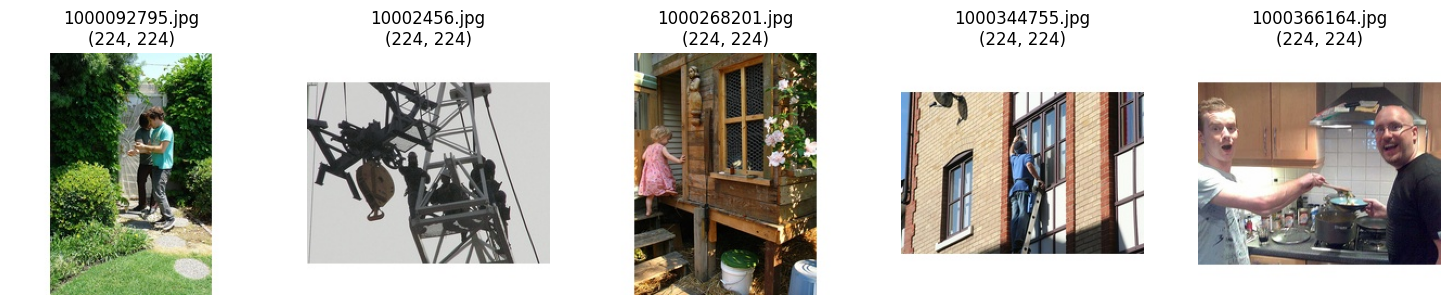

Sample verification completed for 5 images
All images should be (224, 224) pixels


In [9]:
# Verify processed images
def verify_processed_images(sample_size=5):
    """
    Verify a sample of processed images by displaying them.
    """
    processed_files = [f for f in os.listdir(SCALED_IMAGES_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if not processed_files:
        print("No processed images found!")
        return
    
    sample_files = processed_files[:sample_size]
    
    fig, axes = plt.subplots(1, len(sample_files), figsize=(15, 3))
    if len(sample_files) == 1:
        axes = [axes]
    
    for i, filename in enumerate(sample_files):
        img_path = os.path.join(SCALED_IMAGES_PATH, filename)
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{filename}\n{img.size}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Sample verification completed for {len(sample_files)} images")
    print(f"All images should be {TARGET_SIZE} pixels")

# Run verification
verify_processed_images()

In [10]:
# Generate processing summary
def generate_summary():
    """
    Generate a summary of the image processing results.
    """
    processed_files = [f for f in os.listdir(SCALED_IMAGES_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Calculate file sizes
    total_size = 0
    for filename in processed_files:
        file_path = os.path.join(SCALED_IMAGES_PATH, filename)
        total_size += os.path.getsize(file_path)
    
    total_size_mb = total_size / (1024 * 1024)
    
    print("=" * 50)
    print("IMAGE PROCESSING SUMMARY")
    print("=" * 50)
    print(f"Target image size: {TARGET_SIZE}")
    print(f"Scaling method: {SCALING_METHOD}")
    print(f"JPEG quality: {QUALITY}")
    print(f"")
    print(f"Total unique images in dataset: {len(unique_images)}")
    print(f"Successfully processed: {len(processed_files)}")
    print(f"Processing errors: {len(unique_images) - len(processed_files)}")
    print(f"")
    print(f"Output directory: {SCALED_IMAGES_PATH}")
    print(f"Total output size: {total_size_mb:.2f} MB")
    print(f"Average file size: {total_size_mb/len(processed_files):.2f} MB" if processed_files else "N/A")
    print("=" * 50)
    
    return {
        'total_images': len(unique_images),
        'processed_images': len(processed_files),
        'error_count': len(unique_images) - len(processed_files),
        'total_size_mb': total_size_mb,
        'target_size': TARGET_SIZE,
        'scaling_method': SCALING_METHOD
    }

# Generate and display summary
summary = generate_summary()

IMAGE PROCESSING SUMMARY
Target image size: (224, 224)
Scaling method: padding
JPEG quality: 95

Total unique images in dataset: 31783
Successfully processed: 31783
Processing errors: 0

Output directory: ../../data/scaled_images/
Total output size: 636.37 MB
Average file size: 0.02 MB


In [11]:
# Optional: Create a mapping file for processed images
def create_processed_mapping():
    """
    Create a CSV file mapping original filenames to processed filenames.
    """
    processed_files = [f for f in os.listdir(SCALED_IMAGES_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    mapping_data = []
    for filename in unique_images:
        processed_path = os.path.join(SCALED_IMAGES_PATH, filename)
        is_processed = filename in processed_files
        
        mapping_data.append({
            'original_filename': filename,
            'processed_filename': filename if is_processed else None,
            'processed_path': processed_path if is_processed else None,
            'is_processed': is_processed,
            'target_size': f"{TARGET_SIZE[0]}x{TARGET_SIZE[1]}",
            'scaling_method': SCALING_METHOD
        })
    
    mapping_df = pd.DataFrame(mapping_data)
    mapping_file = "../../data/processed_images_mapping.csv"
    mapping_df.to_csv(mapping_file, index=False)
    
    print(f"Processed images mapping saved to: {mapping_file}")
    print(f"Mapping contains {len(mapping_df)} entries")
    
    return mapping_df

# Create mapping file
mapping_df = create_processed_mapping()
display(mapping_df.head())

Processed images mapping saved to: ../../data/processed_images_mapping.csv
Mapping contains 31783 entries


,original_filename,processed_filename,processed_path,is_processed,target_size,scaling_method
0,1000092795.jpg,1000092795.jpg,../../data/scaled_images/1000092795.jpg,True,224x224,padding
1,10002456.jpg,10002456.jpg,../../data/scaled_images/10002456.jpg,True,224x224,padding
2,1000268201.jpg,1000268201.jpg,../../data/scaled_images/1000268201.jpg,True,224x224,padding
3,1000344755.jpg,1000344755.jpg,../../data/scaled_images/1000344755.jpg,True,224x224,padding
4,1000366164.jpg,1000366164.jpg,../../data/scaled_images/1000366164.jpg,True,224x224,padding


## Next Steps

1. **Verify Image Quality**: Check a few processed images manually to ensure they meet your requirements
2. **Update Dataset**: You may want to update your main dataset CSV to include paths to the processed images
3. **VLLM Integration**: Use the processed images from the `scaled_images` directory for your VLLM model
4. **Batch Processing**: If you have more images to process later, you can re-run the processing cells

## Configuration Notes

- **Target Size**: Currently set to 224x224 pixels (standard for many vision models)
- **Scaling Method**: Using padding to maintain aspect ratio (recommended)
- **Quality**: JPEG quality set to 95 for good balance between quality and file size
- **Format**: All images are converted to RGB JPEG format for consistency

You can modify these parameters in the configuration cell and re-run the processing if needed.